# Variational AutoEncoder - CIFAR10


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab_Notebooks/ERA2-Session-21-unet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/ERA2-Session-21-unet


## Install Dependencies

In [2]:
! pip install pytorch-lightning --quiet
! pip install lightning-bolts --quiet

## Import Modules

In [3]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelSummary
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The featu

## DataLoader

In [5]:
BATCH_SIZE = 32

train_dataset = CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(f"Images Shape: {next(iter(train_dataloader))[0].shape}    Labels Shape: {next(iter(train_dataloader))[1].shape}")

Images Shape: torch.Size([32, 3, 32, 32])    Labels Shape: torch.Size([32])


In [7]:
# Label Data Infusion
y = next(iter(train_dataloader))[1]
y = F.one_hot(y, num_classes=10)

y = torch.argmax(y, dim=1).reshape((y.shape[0], 1, 1, 1))
y = torch.ones((32, 1, 32, 32)) * y
y[0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

## Model Architecture

In [8]:
class VAE(pl.LightningModule):
    """
    Lightning Module for VAE
    """
    def __init__(self, enc_out_dim=256, latent_dim=512, input_height=32):
        """
        Constructor
        """
        # Initialize the lightning module
        super().__init__()

        # Save the input params
        self.save_hyperparameters()

        # Encoder Layers
        self.encoder_conv_layers = nn.Sequential(
            self.conv_layer(in_channels=4, out_channels=64),   # Input Channels = 4  [3 for RGB and 1 for label data]
            self.conv_layer(in_channels=64, out_channels=128),
            self.conv_layer(in_channels=128, out_channels=256)
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim * 26 * 26, latent_dim)    # 26 since input image size is reduced to 26 after 3 conv layers
        self.fc_var = nn.Linear(enc_out_dim * 26 * 26, latent_dim)

        # Decoder's Linear Layer
        self.linear = nn.Linear(latent_dim + 10, enc_out_dim * 26 * 26)  # 10 [One for each class]

        # Decoder Layers
        self.decoder_conv_layers = nn.Sequential(
            self.transpose_layer(in_channels=256, out_channels=128),
            self.transpose_layer(in_channels=128, out_channels=64),
            self.transpose_layer(in_channels=64, out_channels=3),
        )

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def conv_layer(self, in_channels, out_channels):
        """
        Function to return conv layer
        """
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, bias=False),
            nn.ReLU()
        )

    def transpose_layer(self, in_channels, out_channels):
        """
        Function to return Transpose layer
        """
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, bias=False),
            nn.ReLU()
        )

    def encoder(self, x, y):
        """
        Encoder Block of the VAE
        """
        # Batch size and input dimensions
        batch_size = x.shape[0]
        img_height = x.shape[2]   # Height = Width

        # Concatenate Label data to the image data
        y = torch.argmax(y, dim=1).reshape((y.shape[0], 1, 1, 1))
        y = torch.ones((batch_size, 1, img_height, img_height)).to(self.device) * y
        concat_input = torch.cat((x, y), dim=1)

        # Pass the concatenated input through the encoder layers and flatten it
        x = self.encoder_conv_layers(concat_input)
        x = x.view(batch_size, -1)
        return x

    def decoder(self, z, y):
        """
        Decoder Block of VAE
        """
        # Add 10 neurons (one for each class to the latent layer)
        z = torch.cat((z, y.float()), dim=1)

        # Latent layer
        x_hat = F.relu(self.linear(z))
        x_hat = x_hat.reshape(-1, 256, 26, 26)

        # Decoder layers
        x_hat = self.decoder_conv_layers(x_hat)
        x_hat = torch.sigmoid(x_hat)
        return x_hat

    def configure_optimizers(self):
        """
        Optimizer for model training
        """
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        """
        """
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        """
        """
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        """
        Function to train the model
        """
        # Input data
        x, y = batch

        # One-Hot encoding of label data
        y = F.one_hot(y, num_classes=10)

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x, y)

        # Encoder output mu and sigma
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z, y)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

## Model Training

In [9]:
# Seed for deterministic results
pl.seed_everything(8)

# Instance of the model
model = VAE()

# Trainer configuration
trainer = pl.Trainer(
    callbacks=[ModelSummary(max_depth=1)],
    gpus=1,
    num_sanity_val_steps=1,
    max_epochs=30
    )

# Train the model
trainer.fit(model, train_dataloader, test_dataloader)

INFO:lightning_fabric.utilities.seed:Global seed set to 8
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: Us

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


## Model Output

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
import numpy as np


def vae_results(x, y, model, classes, correct_labels=True, num_outputs=25):
    """
    Function to display output images generated by the model
    """
    # Figure to display the results
    figure(figsize=(8, 3), dpi=300)
    device = model.device

    # Set the model to eval mode
    with torch.no_grad():
        # Change the value to get incorrect label values
        y_incorrect = y - 1                   # Reduce class value by 1
        y_incorrect[y_incorrect == -1] = 9    # Change -1 to 9

        # One-Hot Encoding
        one_hot_y = F.one_hot(y, num_classes=10)
        one_hot_incorrect_y = F.one_hot(y_incorrect, num_classes=10)

        # Send correct labels to Encoder based on function argument
        if correct_labels:
            x_encoded = model.encoder(x.to(device), one_hot_y.to(device))
        else:
            x_encoded = model.encoder(x.to(device), one_hot_incorrect_y.to(device))

        # Get mean and variance from encoder output
        mu, log_var = model.fc_mu(x_encoded), model.fc_var(x_encoded)

        # Calculate standard deviation
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        # Send correct labels to Decoder based on function argument
        if correct_labels:
            x_hat = model.decoder(z, one_hot_y.to(device))
        else:
            x_hat = model.decoder(z, one_hot_incorrect_y.to(device))

        # Plot Results
        fig = plt.figure(figsize=(10,10))
        for index in np.arange(num_outputs):
            axs = fig.add_subplot(5, 5, index + 1, xticks=[], yticks=[])
            img = x_hat[index].to('cpu')
            plt.imshow(img.permute(1, 2, 0))

            if correct_labels:
                axs.set_title(f"Label: {classes[y[index]]}")
            else:
                axs.set_title(f"Incorrect Label: {classes[y_incorrect[index]]}\n Correct Label: {classes[y[index]]}")

        fig.tight_layout()
        plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Output with Correct Labels

<Figure size 2400x900 with 0 Axes>

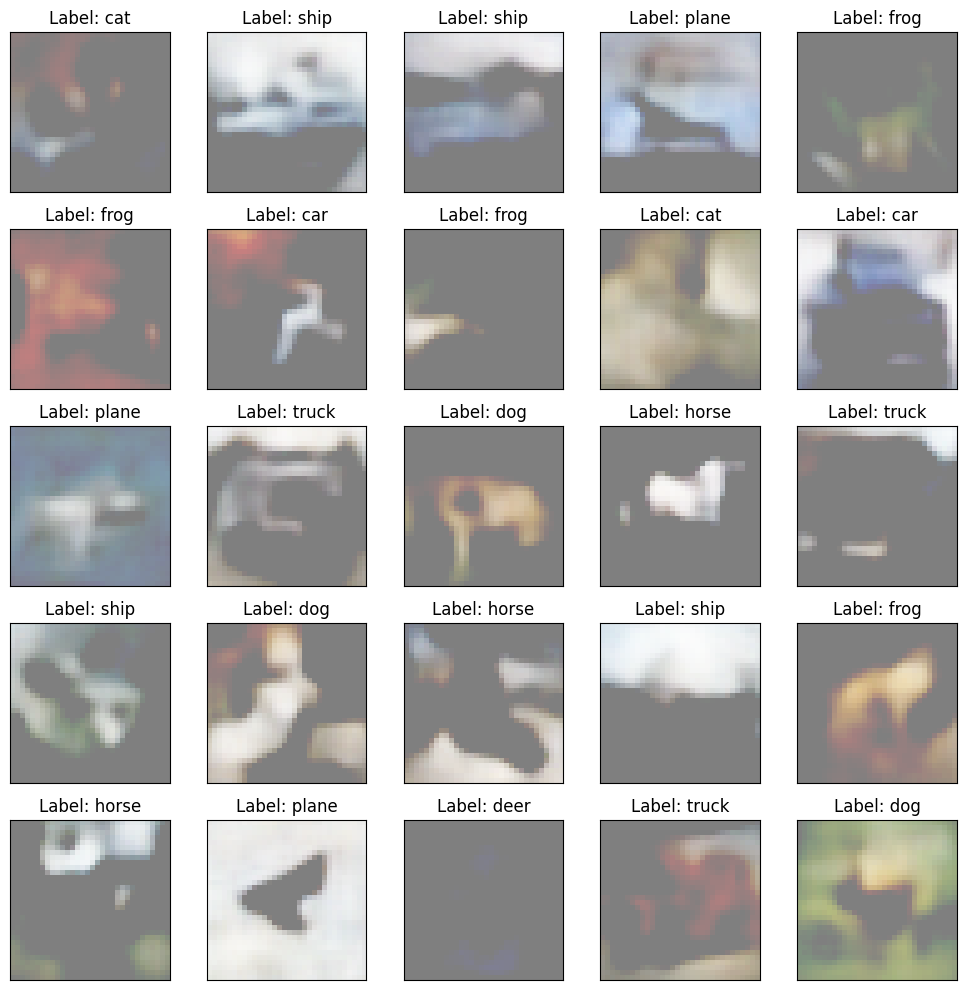

In [11]:
x, y = next(iter(test_dataloader))
vae_results(x, y, model, classes)

### Output with Incorrect Labels

<Figure size 2400x900 with 0 Axes>

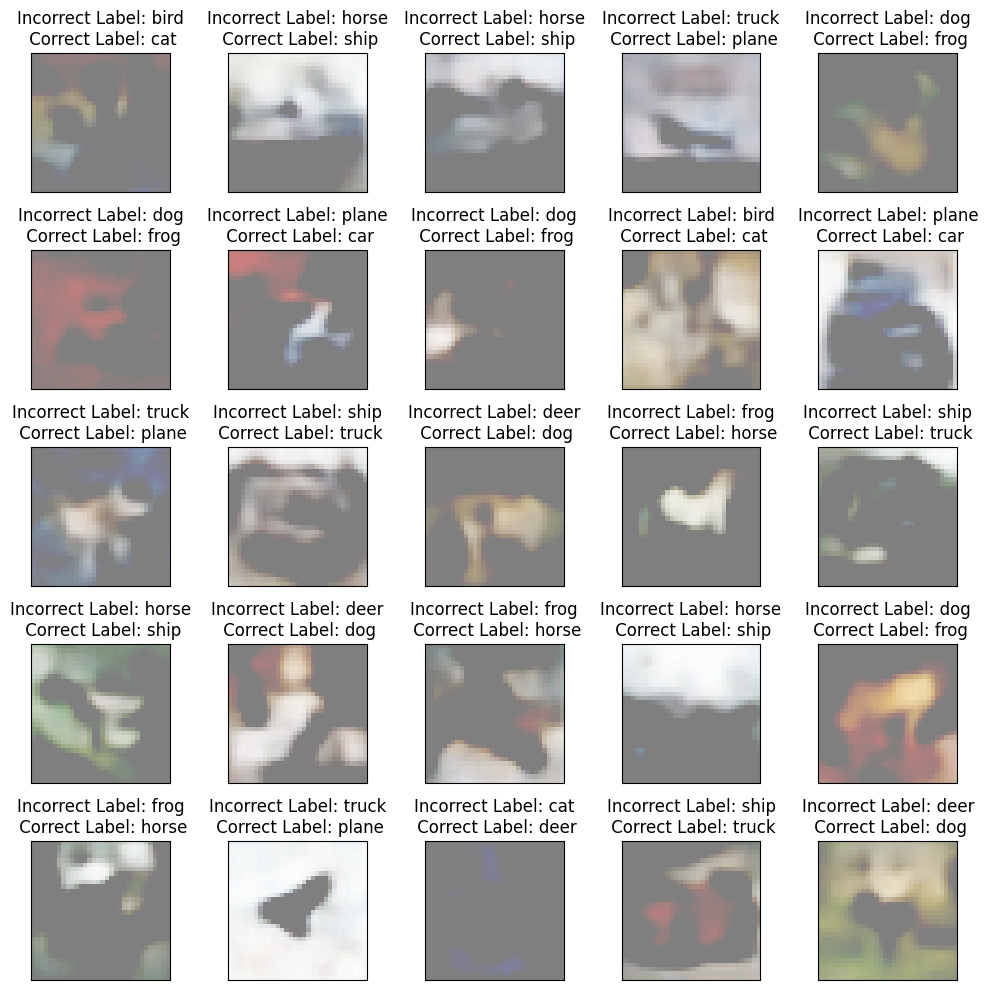

In [12]:
vae_results(x, y, model, classes, correct_labels=False)

### Output with Correct Labels

<Figure size 2400x900 with 0 Axes>

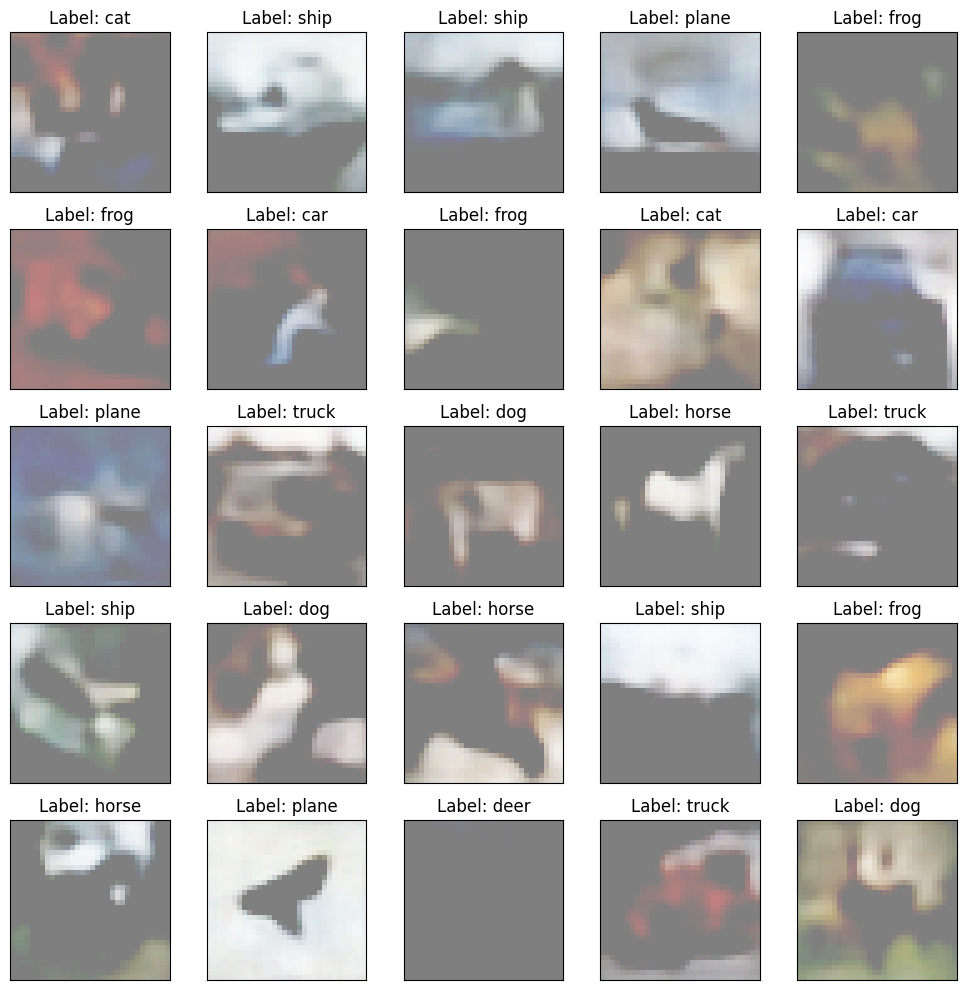

In [13]:
vae_results(x, y, model, classes, correct_labels=True)

In [14]:
torch.save(model.state_dict(), 'vae_cifar_model.pth')